## Installing required python packages

In [ ]:
!pip install streamlit medmnist

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import medmnist
from medmnist import INFO, Evaluator

In [3]:
def download_dataset(data_flag):
  print(f"Dataset source information : MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

  download = True
  
  info = INFO[data_flag]

  DataClass = getattr(medmnist, info['python_class'])

  # print('\nBreastMNIST')
  print(info['description'])

  # Downloading dataset
  train_dataset = DataClass(split='train', download=download)
  val_dataset = DataClass(split='val', download=download)
  test_dataset = DataClass(split='test', download=download)

  print('\nTraining Dataset:')
  print(train_dataset)
  # print(train_dataset.imgs.shape)
  if train_dataset.imgs.ndim == 3:
    print('Adding channel to images...')
    train_dataset.imgs = np.expand_dims(train_dataset.imgs, axis=-1)

  print('\nValidation Dataset:')
  print(val_dataset)
  # print(val_dataset.imgs.shape)
  if val_dataset.imgs.ndim == 3:
    print('Adding channel to images...')
    val_dataset.imgs = np.expand_dims(val_dataset.imgs, axis=-1)

  print('\nTesting Dataset:')
  print(test_dataset)
  # print(test_dataset.imgs.shape)
  if test_dataset.imgs.ndim == 3:
    print('Adding channel to images...')
    test_dataset.imgs = np.expand_dims(test_dataset.imgs, axis=-1)

  print('\nShapes of images:')
  print('Training: ', train_dataset.imgs.shape)
  print('Validation: ', val_dataset.imgs.shape)
  print('Testing: ', test_dataset.imgs.shape)

  return train_dataset, val_dataset, test_dataset

In [4]:
train_dataset, val_dataset, test_dataset = download_dataset('bloodmnist')

Dataset source information : MedMNIST v2.1.0 @ https://github.com/MedMNIST/MedMNIST/
The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.
Using downloaded and verified file: C:\Users\Dhanya Kantheti\.medmnist\bloodmnist.npz
Using downloaded and verified file: C:\Users\Dhanya Kantheti\.medmnist\bloodmnist.npz
Using downloaded and verified file: C:\Users\Dhanya Kantheti\.medmnist\bloodmnist.npz

Training Dataset:
Dataset BloodMNIST (bloodmnist)
    Number of datapoints: 11959
    Root location: C:\Users\Dhanya Kantheti\.medmnist
    Split: train
    Task

In [5]:
class_labels = ['basophil',
                'eosinophil',
                'erythroblast',
                'immature granulocytes',
                'lymphocyte',
                'monocyte',
                'neutrophil',
                'platelet']

## Pre-Processing

In [ ]:
# Check missing images in the dataset
if len(train_dataset.imgs) != 11959:
  print("WARNING: Missing images in training dataset.")
  print(f"Found {len(train_dataset.imgs)}, should be 11959.")
else:
  print("SUCCESS: No missing images in training dataset.")

if len(val_dataset.imgs) != 1712:
  print("WARNING: Missing images in validation dataset.")
  print(f"Found {len(val_dataset.imgs)}, should be 1712.")
else:
  print("SUCCESS: No missing images in validation dataset.")

if len(test_dataset.imgs) != 3421:
  print("WARNING: Missing images in testing dataset.")
  print(f"Found {len(train_dataset.imgs)}, should be 3421.")
else:
  print("SUCCESS: No missing images in test dataset.")

SUCCESS: No missing images in training dataset.
SUCCESS: No missing images in validation dataset.
SUCCESS: No missing images in test dataset.


In [6]:
# Normalising images in the dataset
# Pixel values lie between 0-255, 
# division by 255 will scale the values between 0 and 1
train_dataset.imgs = train_dataset.imgs/255.0 
val_dataset.imgs = val_dataset.imgs/255.0
test_dataset.imgs = test_dataset.imgs/255.0

## Save and Load Models

In [ ]:
# Function to SAVE and LOAD models

from pathlib import Path
from keras.models import model_from_json

def save_model(model, model_name):
  # Saving neural network structure
  model_structure = model.to_json()
  # Saving to file
  f = Path(f"{model_name}.json")
  f.write_text(model_structure)

  #save neural network's saved weights
  model.save_weights(f"{model_name}.h5")

def load_model(model_name):
  f = Path(f"{model_name}.json")
  model_structure = f.read_text()
  model = model_from_json(model_structure)
  model.load_weights(f"{model_name}.h5")
  return model

## Model Evaluation

In [ ]:
# Function for Model Evaluation

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay

def evaluate_model(true_labels, predicted_labels, predicted_probs, label_names):
  if(true_labels.ndim==2):
    true_labels = true_labels[:, 0]
  if(predicted_labels.ndim==2):
    predicted_labels = predicted_labels[:, 0]
  if(predicted_probs.ndim==2):
    predicted_probs = predicted_probs[:, 0]

  print(f"Accuracy : {accuracy_score(true_labels, predicted_labels)}")

  print(f"Precision : {precision_score(true_labels, predicted_labels,average='micro')}")

  print(f"Recall : {recall_score(true_labels, predicted_labels,average='micro')}")

  print(f"F1 Score: {f1_score(true_labels, predicted_labels,average='micro')}")

  # print(f"ROC AUC Score : {roc_auc_score(true_labels, predicted_probs)}")

  print("Classification report : ")
  print(classification_report(true_labels, predicted_labels, target_names=label_names))

  matrix = confusion_matrix(true_labels, predicted_labels)
  print("Confusion Matrix : ")

  ConfusionMatrixDisplay(matrix, display_labels=label_names).plot(cmap=plt.cm.Blues)
  if label_names is not None:
        tick_marks = np.arange(len(label_names))
        plt.xticks(tick_marks, label_names, rotation=45)
        plt.yticks(tick_marks, label_names)

## Visualisation

In [ ]:
# Function to plot Accuracy and Loss of a model

def plot_acc_loss(model_history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6), dpi=160)
  acc = model_history.history['accuracy']
  val_acc = model_history.history['val_accuracy']

  # Get number of epochs
  epochs = range(1, len(acc) + 1)

  # Plot training and validation accuracy per epoch
  ax1.plot(epochs, acc, label="Training acc")
  ax1.plot(epochs, val_acc, label="Validation acc")
  ax1.set_title('Training and validation accuracy')
  ax1.legend()

  loss = model_history.history['loss']
  val_loss = model_history.history['val_loss']

  ax2.plot(epochs, loss, label="Training loss")
  ax2.plot(epochs, val_loss, label="Validation loss")
  ax2.set_title('Training and validation loss')
  ax2.legend()

In [ ]:
# Function to visualise a subset of the dataset
def visualise_subset(train_dataset):
  fig = plt.figure(figsize=(12, 10))
  for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(train_dataset.imgs[i], cmap=plt.get_cmap('gray'))
    plt.title(f"Class {train_dataset.labels[i][0]}")
  plt.show()

In [7]:
import tensorflow as tf
from keras.utils import plot_model
from tensorflow import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

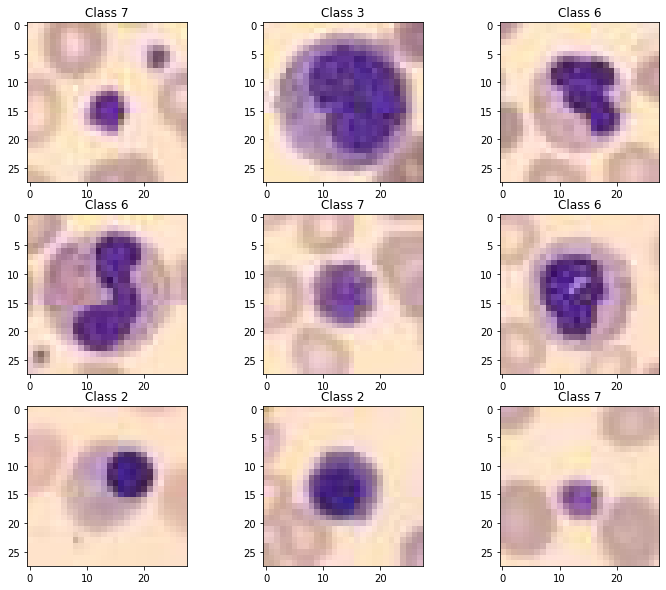

In [ ]:
visualise_subset(train_dataset)

In [8]:
def augmented_data_visualisation(train_dataset):
  datagen = ImageDataGenerator(rotation_range=30)
  train_generator = datagen.flow(train_dataset.imgs,train_dataset.labels)
  plt.figure(figsize=(10,5))
  for i in range(6):
    plt.subplot(2,3,i+1)
    for x,y in train_generator:
      plt.imshow((x[0]/255),cmap='gray')
      plt.title('y={}'.format(y[0]))
      plt.axis('off')
      break
  plt.tight_layout()
  plt.show()

## Class Imbalance

In [ ]:
# Class Imbalance handling through class weights calculation

from sklearn.utils import class_weight
import numpy as np

blood_class_weights = class_weight.compute_class_weight('balanced',
                                                         classes = np.unique(train_dataset.labels[:,0]),
                                                         y = train_dataset.labels[:, 0])

weights = {0 : blood_class_weights[0], 
           1 : blood_class_weights[1], 
           2 : blood_class_weights[2], 
           3 : blood_class_weights[3], 
           4 : blood_class_weights[4], 
           5 : blood_class_weights[5], 
           6 : blood_class_weights[6], 
           7 : blood_class_weights[7] }

print(f"Class weights for imbalance {weights}")

Class weights for imbalance {0: 1.7545481220657277, 1: 0.6854080696928014, 2: 1.3777649769585254, 3: 0.7378455083909181, 4: 1.7607479387514724, 5: 1.5054128902316213, 6: 0.6415772532188841, 7: 0.9098447961046866}


## Data Augmentation


In [ ]:
print("Preprocessing and augmentation of images with Standardisation, Rotation and Horizontal Flips..")
datagen = ImageDataGenerator(rotation_range=10,
                             horizontal_flip=True)

Preprocessing and augmentation of images with Standardisation, Rotation and Horizontal Flips..


In [ ]:
my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=10)]

In [ ]:
# One-hot encoding of labels (multi-class classification)
train_labels = to_categorical(train_dataset.labels, num_classes=8)
val_labels = to_categorical(val_dataset.labels, num_classes=8)

## Model 1: Own model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=(28, 28, 3), activation="relu"))
model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(8, activation="softmax"))

In [ ]:
# Printing model summary
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 13, 13, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        36928     
                                                        

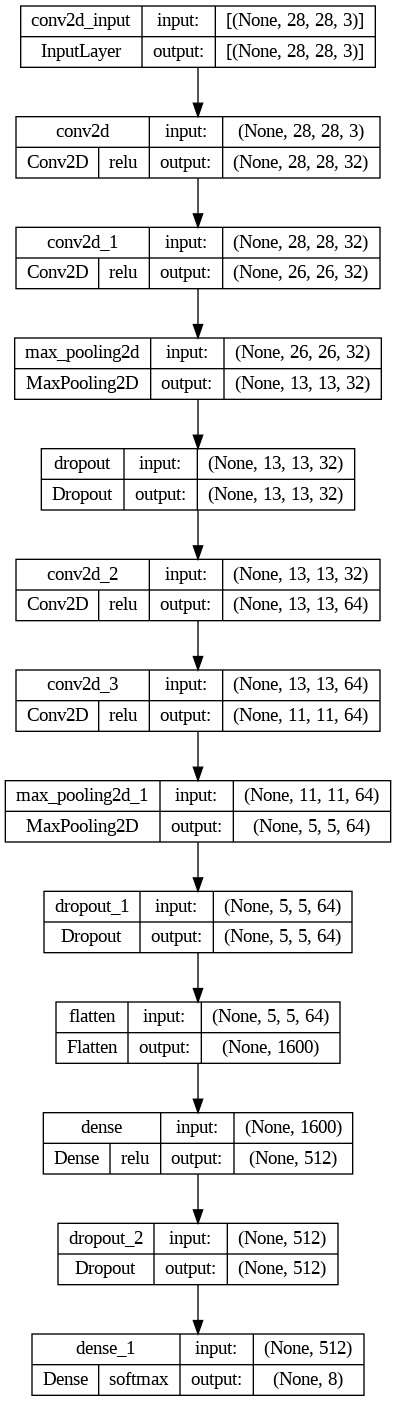

In [ ]:
# Plotting model architecture
plot_model(model, to_file='model_from_scratch_blood.png', show_shapes=True, show_layer_activations=True)

In [ ]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
# Training the model
history = model.fit(datagen.flow(train_dataset.imgs, train_labels),
                    epochs=100,
                    callbacks=my_callbacks,
                    validation_data=(val_dataset.imgs, val_labels),
                    shuffle=True,
                    class_weight=weights)

Epoch 1/100
374/374 [==============================] - 61s 159ms/step - loss: 1.1758 - accuracy: 0.5495 - val_loss: 0.8368 - val_accuracy: 0.6787
Epoch 2/100
374/374 [==============================] - 57s 154ms/step - loss: 0.7424 - accuracy: 0.7368 - val_loss: 0.4944 - val_accuracy: 0.8254
Epoch 3/100
374/374 [==============================] - 58s 156ms/step - loss: 0.5836 - accuracy: 0.8050 - val_loss: 0.4593 - val_accuracy: 0.8452
Epoch 4/100
374/374 [==============================] - 58s 156ms/step - loss: 0.5009 - accuracy: 0.8294 - val_loss: 0.3621 - val_accuracy: 0.8750
Epoch 5/100
374/374 [==============================] - 60s 161ms/step - loss: 0.4516 - accuracy: 0.8471 - val_loss: 0.2909 - val_accuracy: 0.8978
Epoch 6/100
374/374 [==============================] - 56s 149ms/step - loss: 0.4308 - accuracy: 0.8554 - val_loss: 0.3356 - val_accuracy: 0.8715
Epoch 7/100
374/374 [==============================] - 54s 143ms/step - loss: 0.3802 - accuracy: 0.8692 - val_loss: 0.2843 -

In [ ]:
save_model(model, "model_from_scratch_blood")

In [ ]:
# Predictions on test dataset
test_predict_prob = model.predict(test_dataset.imgs, verbose=0)
test_predict_labels = np.argmax(test_predict_prob,axis=-1)

Accuracy : 0.9453376205787781
Precision : 0.9453376205787781
Recall : 0.9453376205787781
F1 Score: 0.945337620578778
Classification report : 
                       precision    recall  f1-score   support

             basophil       0.87      0.91      0.89       244
           eosinophil       0.99      0.99      0.99       624
         erythroblast       0.98      0.94      0.96       311
immature granulocytes       0.91      0.84      0.87       579
           lymphocyte       0.89      0.98      0.93       243
             monocyte       0.87      0.89      0.88       284
           neutrophil       0.95      0.98      0.97       666
             platelet       1.00      1.00      1.00       470

             accuracy                           0.95      3421
            macro avg       0.93      0.94      0.94      3421
         weighted avg       0.95      0.95      0.95      3421

Confusion Matrix : 


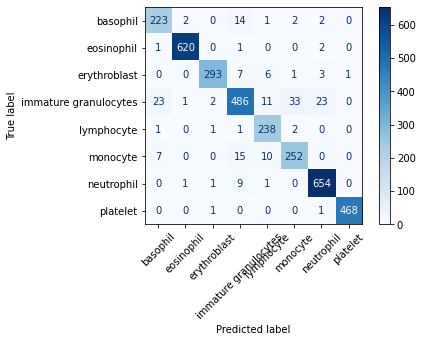

In [ ]:
# Model evaluation
evaluate_model(test_dataset.labels, test_predict_labels, test_predict_prob, class_labels)

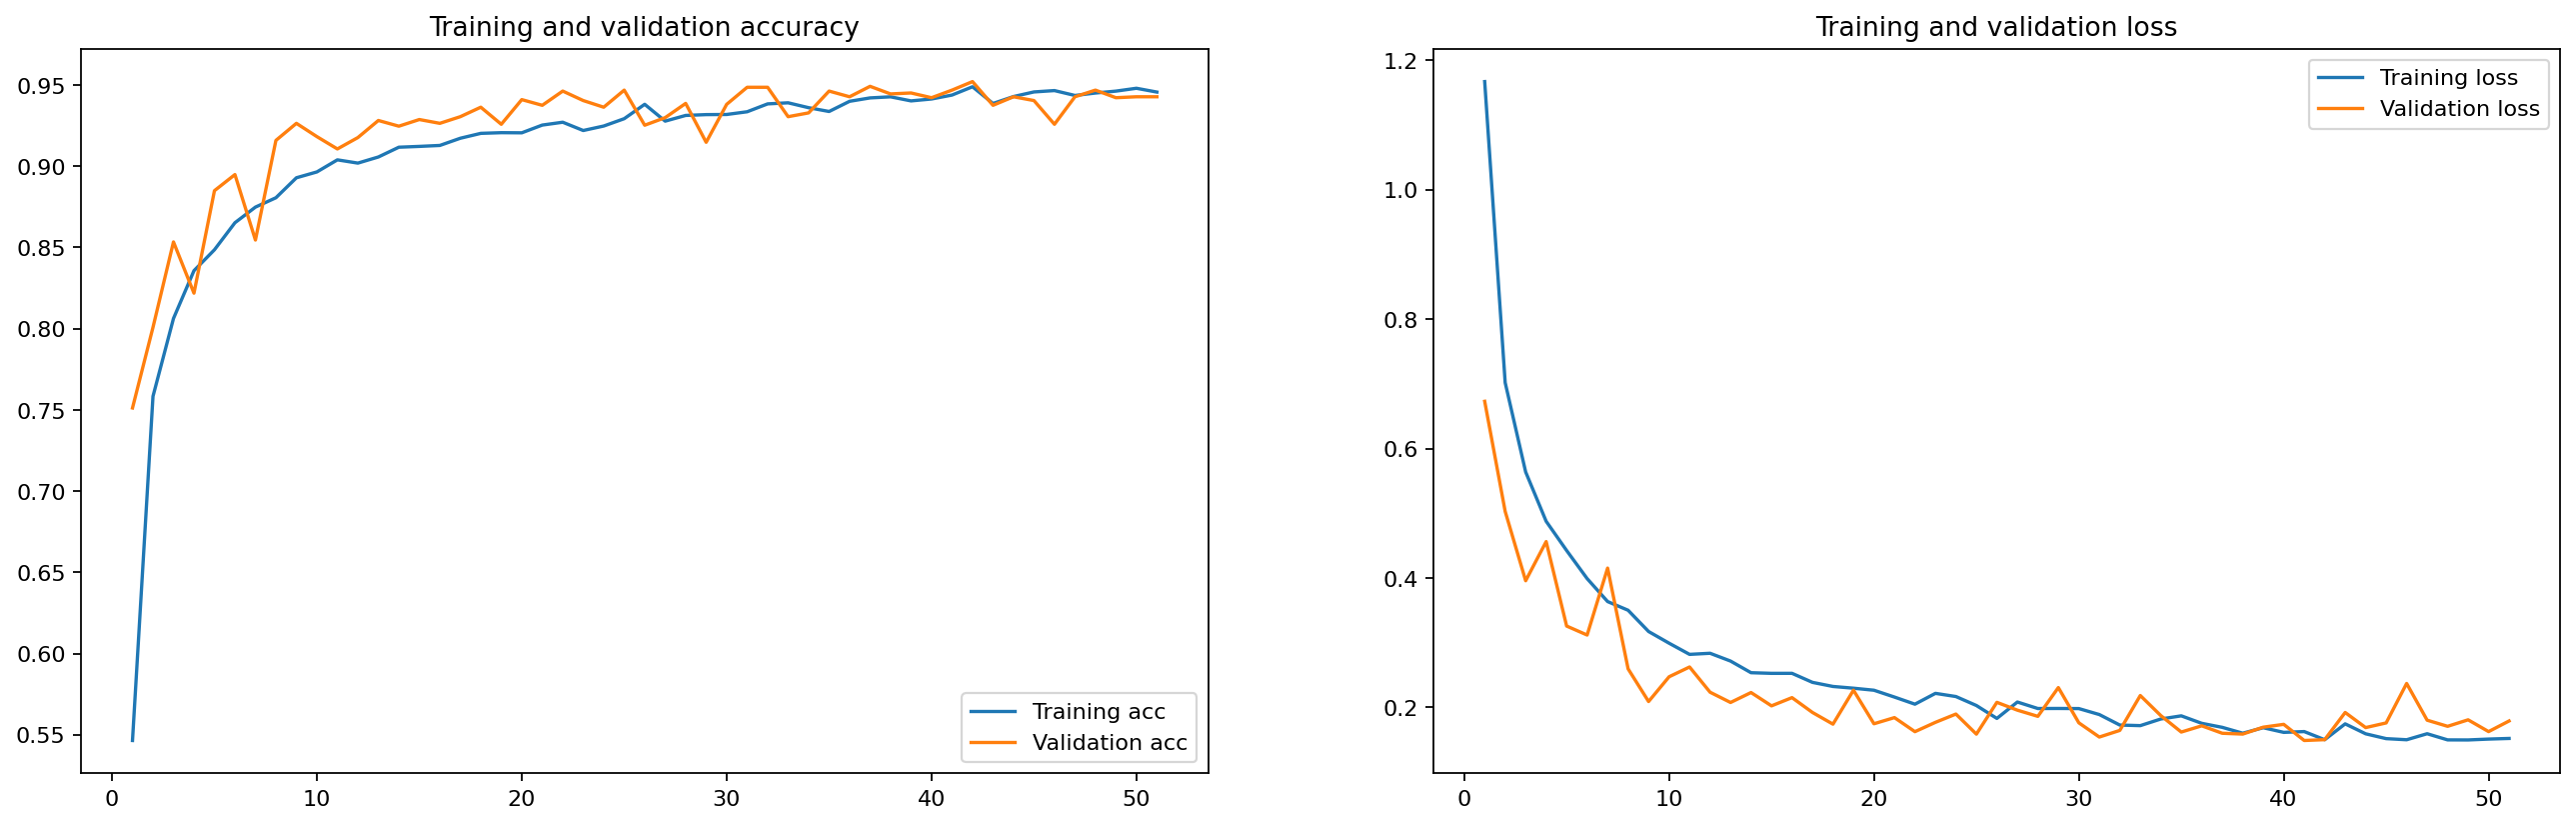

In [ ]:
# Plotting accuracy and loss
plot_acc_loss(history)

# Model 2: Transfer Learning VGG16

In [ ]:
from tensorflow import keras

vgg16 = keras.applications.vgg16

In [ ]:
conv_model = vgg16.VGG16(weights='imagenet', 
                         include_top=False,
                         input_shape=(32,32,3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
for layer in conv_model.layers: 
    layer.trainable = False

In [ ]:
x = keras.layers.Flatten()(conv_model.output)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dense(32, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
predictions = keras.layers.Dense(8, activation='softmax')(x)
full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)
full_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [ ]:
full_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
new_train_dataset, new_val_dataset, new_test_dataset = download_dataset('bloodmnist')

Dataset source information : MedMNIST v2.1.0 @ https://github.com/MedMNIST/MedMNIST/
The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.
Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist.npz

Training Dataset:
Dataset BloodMNIST (bloodmnist)
    Number of datapoints: 11959
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basoph

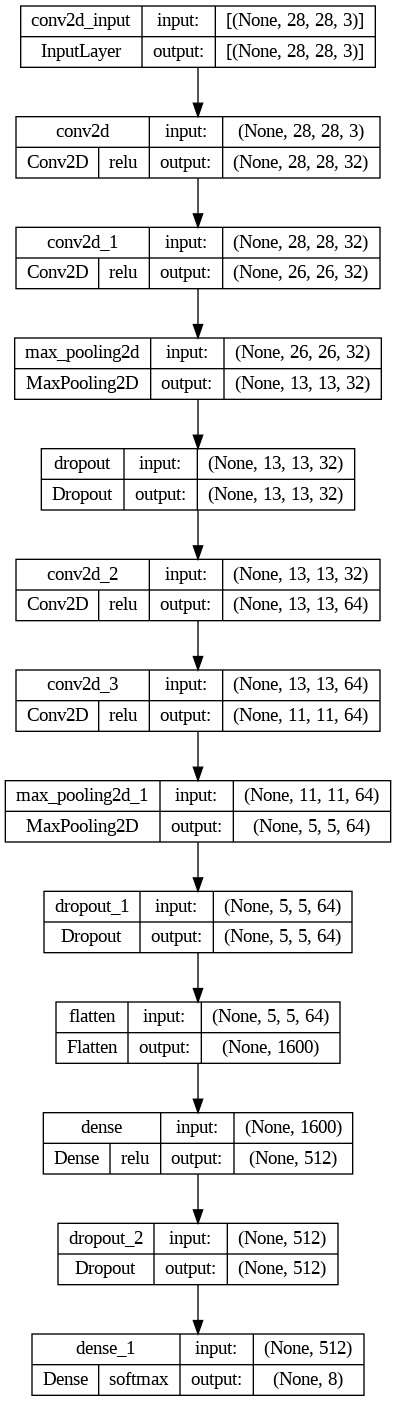

In [ ]:
# Plotting model architecture
plot_model(model, to_file='vgg16.png', show_shapes=True, show_layer_activations=True)

In [ ]:
new_train_dataset.imgs = new_train_dataset.imgs/255.0
new_val_dataset.imgs = new_val_dataset.imgs/255.0
new_test_dataset.imgs = new_test_dataset.imgs/255.0

In [ ]:
# Change the shape as nx32x32x3 by padding with zeros
# Ref: https://datascience.stackexchange.com/questions/38351/padding-on-mnist-for-lenet-architecture
new_train_dataset.imgs = np.pad(new_train_dataset.imgs, ((0,0),(2,2),(2,2),(0,0)), 'constant')
new_val_dataset.imgs = np.pad(new_val_dataset.imgs, ((0,0),(2,2),(2,2),(0,0)), 'constant')

In [ ]:
history = full_model.fit(new_train_dataset.imgs, train_labels,
                         epochs=100,
                         # callbacks=my_callbacks,
                         validation_data=(new_val_dataset.imgs, val_labels),
                         shuffle=True,
                         class_weight=weights)

Epoch 1/100
374/374 [==============================] - 7s 13ms/step - loss: 1.2897 - accuracy: 0.5288 - val_loss: 0.7515 - val_accuracy: 0.7190
Epoch 2/100
374/374 [==============================] - 4s 12ms/step - loss: 0.9271 - accuracy: 0.6754 - val_loss: 0.6062 - val_accuracy: 0.7763
Epoch 3/100
374/374 [==============================] - 4s 11ms/step - loss: 0.8182 - accuracy: 0.7198 - val_loss: 0.5468 - val_accuracy: 0.7956
Epoch 4/100
374/374 [==============================] - 4s 11ms/step - loss: 0.7632 - accuracy: 0.7341 - val_loss: 0.5361 - val_accuracy: 0.7891
Epoch 5/100
374/374 [==============================] - 5s 14ms/step - loss: 0.7199 - accuracy: 0.7503 - val_loss: 0.5203 - val_accuracy: 0.8143
Epoch 6/100
374/374 [==============================] - 4s 11ms/step - loss: 0.6947 - accuracy: 0.7661 - val_loss: 0.4809 - val_accuracy: 0.8347
Epoch 7/100
374/374 [==============================] - 4s 11ms/step - loss: 0.6674 - accuracy: 0.7765 - val_loss: 0.5327 - val_accuracy:

In [ ]:
save_model(model, "vgg16")

In [ ]:
# Predictions on test dataset
test_predict_prob = model.predict(test_dataset.imgs, verbose=0)
test_predict_labels = np.argmax(test_predict_prob,axis=-1)

Accuracy : 0.9453376205787781
Precision : 0.9453376205787781
Recall : 0.9453376205787781
F1 Score: 0.945337620578778
Classification report : 
                       precision    recall  f1-score   support

             basophil       0.87      0.91      0.89       244
           eosinophil       0.99      0.99      0.99       624
         erythroblast       0.98      0.94      0.96       311
immature granulocytes       0.91      0.84      0.87       579
           lymphocyte       0.89      0.98      0.93       243
             monocyte       0.87      0.89      0.88       284
           neutrophil       0.95      0.98      0.97       666
             platelet       1.00      1.00      1.00       470

             accuracy                           0.95      3421
            macro avg       0.93      0.94      0.94      3421
         weighted avg       0.95      0.95      0.95      3421

Confusion Matrix : 


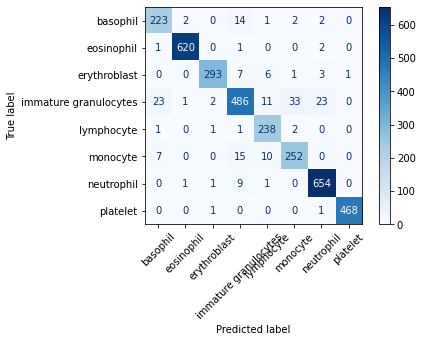

In [ ]:
# Model evaluation
evaluate_model(test_dataset.labels, test_predict_labels, test_predict_prob, class_labels)

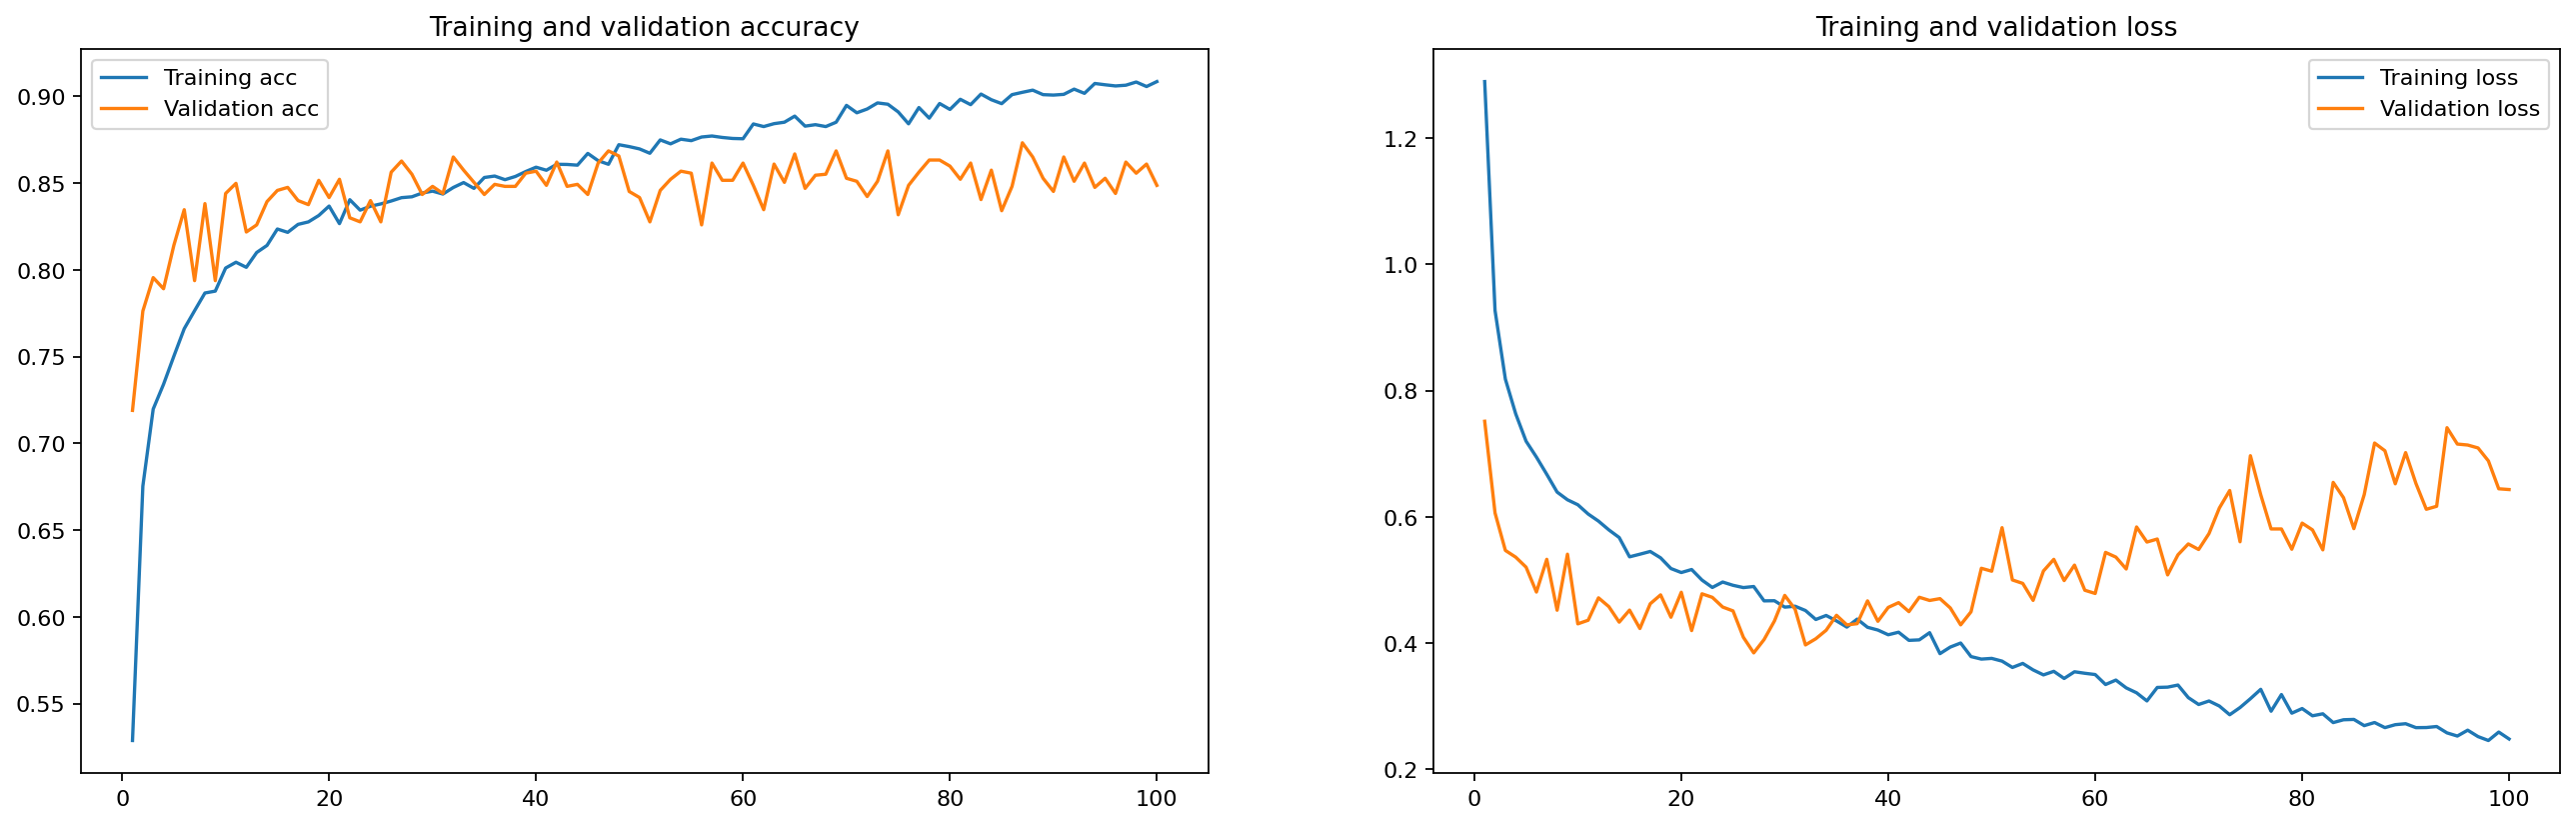

In [ ]:
# Plotting accuracy and loss
plot_acc_loss(history)